# Dimensionality reduction

`Unsupervised learning II` `Author: Emily Hunt`

## Introduction

### All dimensions are equal, but some are more equal than others

In science, high-dimensional data are common. For instance, take a spectrum of a star: it can contain tens or even hundreds of thousands of 'pixels' of information about a source. Each pixel encodes information about the star. However, some (or even many!) pixels are measuring the same _fundamental properties_ of the star: its temperature, surface gravity, metallicity, abundances, etc...

**Dimensionality reduction** is a family of methods for reducing the number of input dimensions in a dataset to only its most significant dimensions. It works on the assumption that, for $N$ measurements of a phenomenon, the phenonmenon can be described by just $M$ dimensions, where $M < N$. In fact, it's often that $M << N$.

We'll see that there are a wide range of methods for doing this. Some of the simplest, like Principal component analysis (PCA), are a simple and traditional method that still has use today. Some fancier methods (like t-SNE or UMAP) use 'fancy maths' to completely transform a dataset into a low-dimensional embedding.

In a way, **dimensionality reduction** is the unsupervised analogue to **supervised regression**. In regression, we typically take a large number of inputs and transform them into a small number of outputs - exactly what dimensionality reduction does! However, the catch is that we don't choose what outputs we transform to...

### Principal component analysis (PCA)

At least for PCA, I think it is worth having a little bit of theoretical background - it's also the easiest method to understand the inner workings of for the ones that we'll try today.

PCA effectively works by **rotating** your dataset to make the $i^\text{th}$ component always contain more **variance** than the $(i+1)^\text{th}$ component - that is to say, the **most important** things will be captured by the first few components of your data.

[This example](https://setosa.io/ev/principal-component-analysis/) is fun to get some intuition for this and is better than any plot I can put here, and I'll show it in the lecture. Try playing with the example at the top. If you put the five data points in a line, then PCA finds that just one component (measuring the distance along the line) is enough to describe it. On the other hand, more complicated data (such as a totally random distribution) still requires two components.

## Imports, dependencies, & basic helpers

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from pathlib import Path

## Playing with PCA

### In two dimensions

Let's have a look at how to use PCA in code. As a toy example, here's a little dataset of just some Gaussian scatter, in two dimensions:

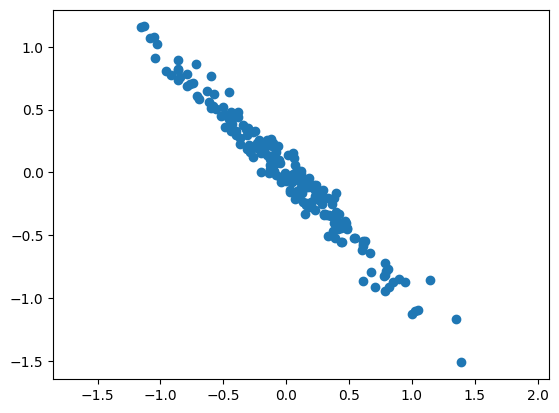

In [24]:
rng = np.random.default_rng(seed=42)
data = rng.normal(scale=(1, 0.1), size=(200, 2)) @ np.asarray([[0.5, -0.5], [0.5, 0.5]])

plt.scatter(data[:, 0], data[:, 1])
plt.gca().set_aspect("equal", adjustable="datalim")

Now let's apply PCA:

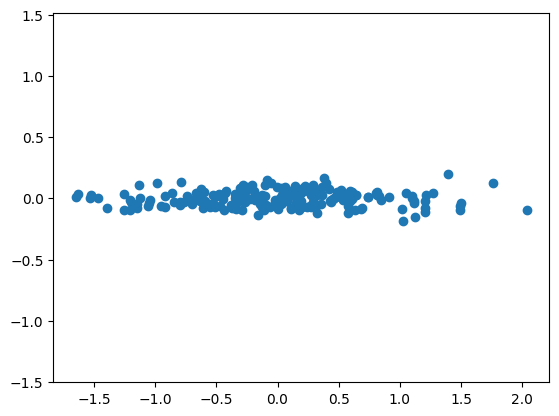

In [30]:
dimensionality_reducer = PCA()
data_reduced = dimensionality_reducer.fit_transform(data)

plt.scatter(data_reduced[:, 0], data_reduced[:, 1])
plt.gca().set_aspect("equal", adjustable="datalim")

We can see that our scattered line has been flattened!

The scikit-learn PCA implementation also has some useful things, like an attribute (after calling `fit()`) saying what the **variance** of each principal component is:

In [34]:
dimensionality_reducer.explained_variance_

array([0.48880086, 0.0041816 ])

we can also see this as a ratio:

In [35]:
dimensionality_reducer.explained_variance_ratio_

array([0.99151774, 0.00848226])

So, 99% of the variance of our data can be explained by just two components!

We can always undo the PCA too!

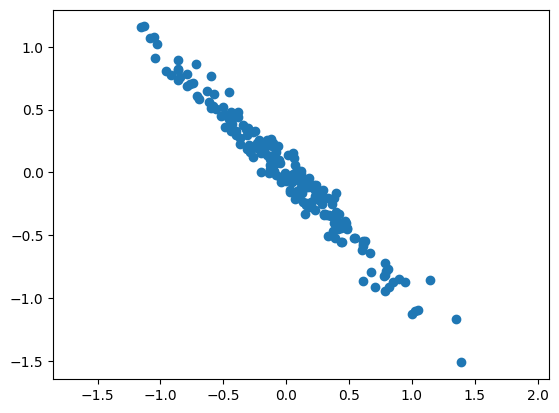

In [59]:
data_unreduced = dimensionality_reducer.inverse_transform(data_reduced)

plt.scatter(data_unreduced[:, 0], data_unreduced[:, 1])
plt.gca().set_aspect("equal", adjustable="datalim")

### Using fewer components

The scikit-learn PCA has a nice way to use fewer (final) components of your data. Generally, the workflow is to do PCA, see how many components you think you need, and then do PCA again with `n_components` set lower.

So, let's take that example again and use just one component:

In [60]:
dimensionality_reducer = PCA(n_components=1)
data_reduced = dimensionality_reducer.fit_transform(data)

We now just have 1D data, which we can see from looking at the first ten components:

In [68]:
data_reduced[:10]

array([[ 0.19947414],
       [ 0.51544236],
       [-1.3956629 ],
       [ 0.07469473],
       [-0.02779523],
       [ 0.60655499],
       [ 0.03156633],
       [ 0.31465604],
       [ 0.2447845 ],
       [ 0.60555405]])

Notice that we cannot completely reconstruct our original dataset when we have fewer components:

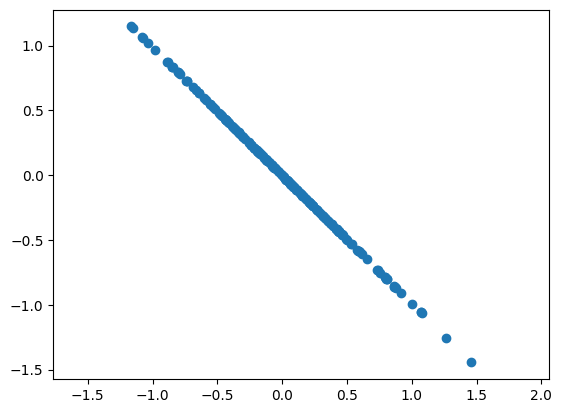

In [69]:
data_unreduced = dimensionality_reducer.inverse_transform(data_reduced)

plt.scatter(data_unreduced[:, 0], data_unreduced[:, 1])
plt.gca().set_aspect("equal", adjustable="datalim")

... the scatter is gone. But it's close!

## EXERCISE 1: Reducing spectra to principal components

### Gaia XP spectra

The Gaia satellite also takes low-resolution spectra of stars. These spectra are usually served in a dimensionality-reduced representation, with just 50 components to represent a full spectrum.

Let's reproduce this as a nice example of how PCA can be used (although Gaia actually uses a different system with polynomials, we can also get good results with PCA.)

In [136]:
# Try to read from local directory; otherwise, get from online source
local_path = Path("../data/100_gaia_xp_spectra.parquet")
url_path = "https://raw.githubusercontent.com/emilyhunt/machine-learning-tutorial-MWGaia-DN/main/data/100_gaia_xp_spectra.parquet"

if local_path.exists():
    spectra = pd.read_parquet(local_path)
else:
    spectra = pd.read_parquet(url_path)

flux_columns = [col for col in spectra.columns if "flux" in col and "error" not in col]
spectra_array = spectra[flux_columns].to_numpy()

This dataset contains a sample of 100 raw Gaia XP spectra for stars in a similar (bright) magnitude range.

Let's plot the first ten:

[Text(0.5, 0, 'Pixel'), Text(0, 0.5, 'Flux')]

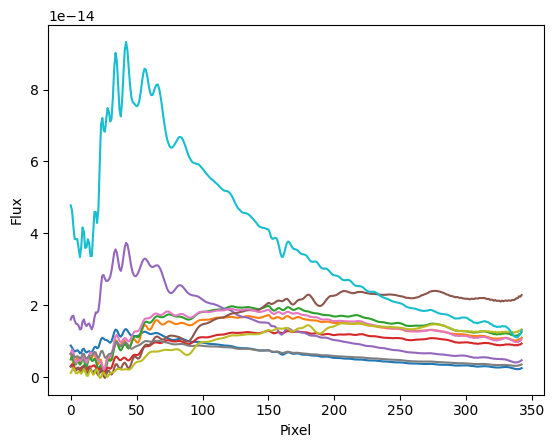

In [137]:
temperature_order = np.argsort(spectra['teff_gspphot'])

fig, ax = plt.subplots()

for spectrum in spectra_array[:10]:
    ax.plot(spectrum)
    
ax.set(xlabel="Pixel", ylabel="Flux")

### Task 1: doing PCA

**Do PCA on the raw spectra in `spectra_array`. Look at the `explained_variance_ratio_` and see what an appropriate number of components would be.**

Hint: use `np.cumsum` to cumulatively sum the variance ratios and plot that against number of components.

### Task 2: PCA forwards and backwards

**Now try doing PCA at an `n_components` of your choice.**

**Try to transforming and untransforming the spectra (as in the 'using fewer components' section) and see how good your `n_components` value is at reproducing your spectra.**

Do you think this would work better or worse if we used more than 100 spectra?

### Extra, if you have time:

* Try plotting the different dimensions of the PCA against parameters calculated by the Gaia astrophysical parameters pipeline - `teff_gspphot`, `logg_gspphot`, `mh_gspphot`, `distance_gspphot`, and `azero_gspphot` / `ag_gspphot` in the `spectra` dataframe. Can you find any trends?
* Try a range of values of `n_components` and compare them against each other.

## DISCUSSION: What types of data are _not_ likely to be well-reduced by a rotation?

## EXERCISE 2: Using t-SNE to create a low-dimensional embedding of spectra

### t-SNE

PCA is nice because it's simple. But it's also inherently limited because it can only do "rotations" of a dataset.

Other methods like [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and [UMAP](https://umap-learn.readthedocs.io/en/latest/) generally perform significantly better on particularly complicated or high-dimensional data (like images).

We'll look at t-SNE (T-distributed Stochastic Neighbor Embedding) and use it on our spectra. But first, here's an example!

### Using t-SNE on the classic dataset (MNIST digits)

(adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py)

A very classic test dataset in machine learning is the 'MNIST digits' or simply 'digits' dataset of handwritten letters from 0 to 10. Let's apply t-SNE to it to see how it does.

Here's the dataset (we'll just use the first six numbers):

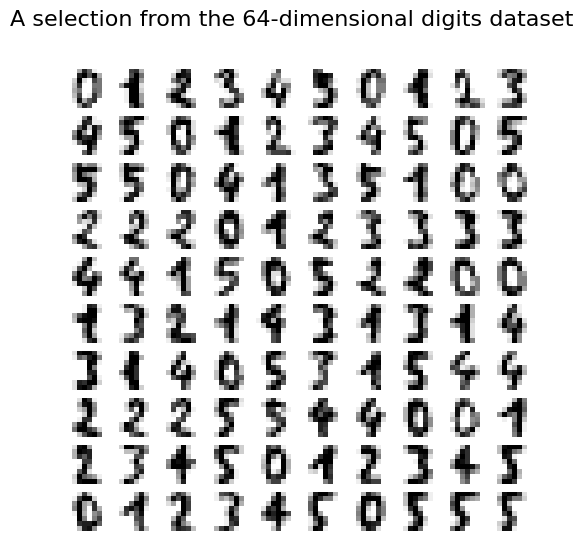

In [115]:
digits = load_digits(n_class=6)
data, classes = digits.data, digits.target

fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))

for i, an_ax in enumerate(ax.flatten()):
    an_ax.imshow(data[i].reshape((8, 8)), cmap=plt.cm.binary)
    an_ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

Classifying these 8x8 pixel images is already a decent test for an image classifier like a CNN. But we can just do it blindly with embedding methods like t-SNE!

In [116]:
embedder = TSNE(
    n_components=2,
    max_iter=500,
    n_iter_without_progress=150,
    n_jobs=2,
    random_state=0,
)
projection = embedder.fit_transform(data)

Done here in 2D, t-SNE groups the images into **distinct groups.**

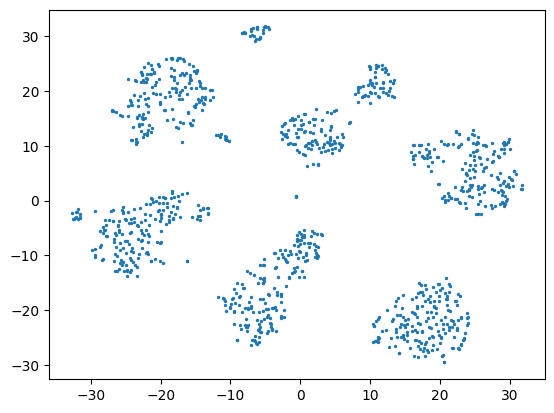

In [121]:
plt.scatter(projection[:, 0], [projection[:, 1]], s=2)

What's **really cool** is that these groups correspond to the actual values of the digits:

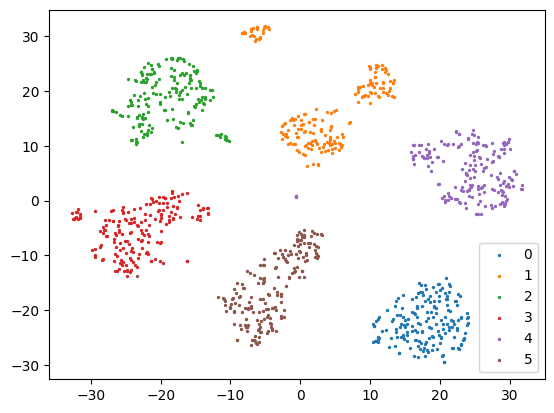

In [127]:
for digit in np.unique(classes):
    matches = classes == digit
    plt.scatter(projection[matches, 0], [projection[matches, 1]], s=2, label=digit)
plt.legend()

This can already tell us some interesting things about our data! For instance:
- The number 1 is drawn differently by different people
- Some numbers (especially 4) are quite similar, but can have extreme outliers.

In principle, we could now apply a clustering algorithm to the t-SNE embedding and match the clusters to each digit number: creating a classifier for our images!

**However**, as we'll see, these embedding methods are also very sensitive to their input parameters.. 

### Task 1: applying t-SNE to the spectra

**Run t-SNE on our spectra from before. See if the features it finds correlate well with the actual parameters of the stars, such as their temperature and metallicity.**

Parameters to investigate in the `spectra` dataframe:
- temperature: `teff_gspphot`
- $\log g$: `logg_gspphot`
- $[M/H]$: `mh_gspphot`
- distance: `distance_gspphot`
- extinction: `azero_gspphot` / `ag_gspphot`

**For now, just use the same t-SNE settings as on the digits example.**

Hints:
- `ax.scatter` accepts a colour argument `c` which can be an array of numbers, such as the parameter you want to compare against. This is a really easy way to make such plots!
- The stellar temperatures span a pretty big range. You may want to compare against log temperature instead

### Task 2: tweaking t-SNE

**t-SNE has a number of parameters that control the final shape of the embedding. Try changing the `perplexity`, `learning_rate`, and `early_exaggeration` parameters to different values.**

**What happens? Are the new embeddings 'better' or 'worse'?**

Hint: [link to the documentation for `TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

### Task 3: looking at an excellent blog post

**Have a look at [this excellent blog post](https://distill.pub/2016/misread-tsne/) about how to use t-SNE.**

**Play with the example at the top. Do you think t-SNE can be misleading?**

If you have time, you can also read the whole thing. It's good!

## DISCUSSION: Do you think that t-SNE is reliable enough to use in a scientific paper? What would you use it for?